In [74]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 4
Finished Aligning, warp matrices=[array([[ 1.00113809e+00, -2.97974399e-03, -1.42893505e+01],
       [ 2.25934759e-03,  1.00269306e+00, -8.68335056e+00],
       [-1.49086293e-06,  1.87856301e-07,  1.00000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0018799e+00, -8.0130348e-04, -1.3155575e+01],
       [ 1.6345379e-03,  1.0012231e+00,  3.1464071e+01],
       [ 1.3314833e-06, -1.7502012e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0039234e+00, -1.9246356e-03, -1.5170276e+01],
       [ 1.6072228e-03,  1.0021683e+00, -6.5288119e+00],
       [ 7.0376871e-07, -9.8100429e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0002850e+00, -4.3783155e-03, -1.5765796e+01],
       [ 1.9523825e-03,  9.9798954e-01,  6.

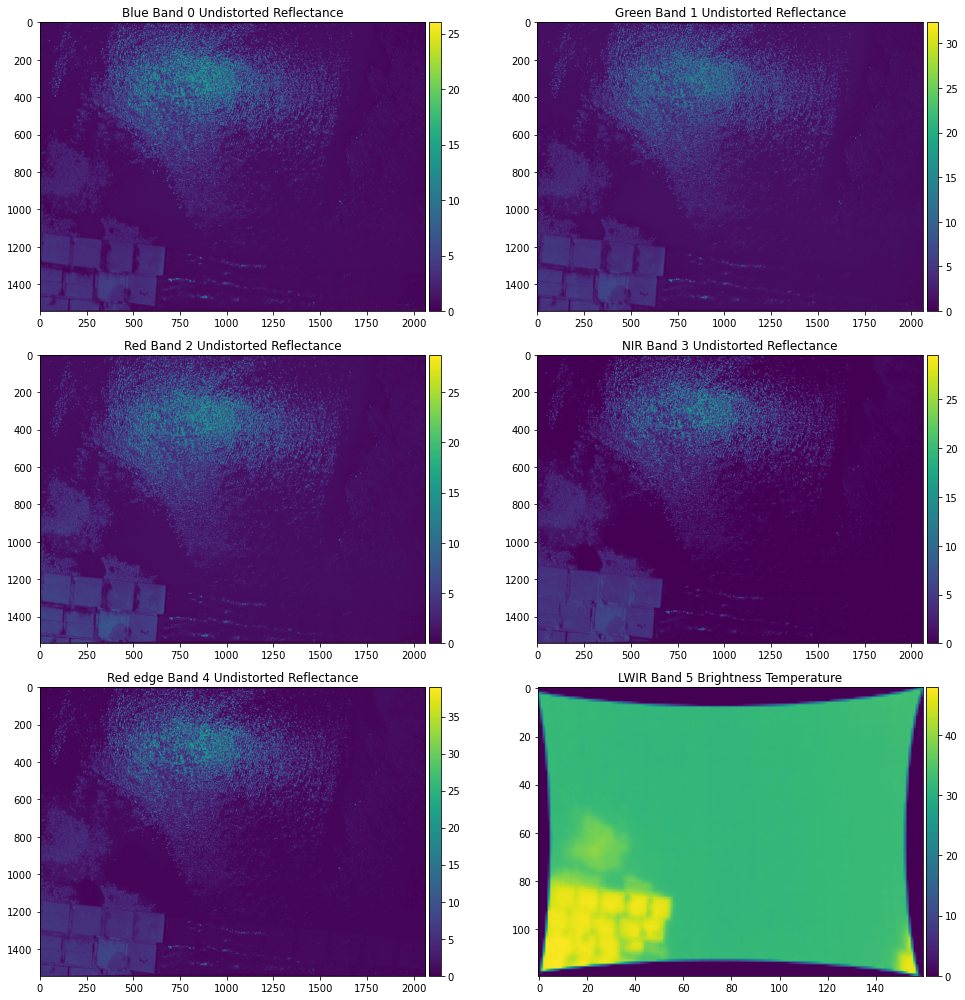

In [76]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# # This is an older RedEdge image without RigRelatives
# imagePath = os.path.join(os.path.abspath('.'),'data','0000SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0070_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

# # Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))
# imageNames = glob.glob(os.path.join(imagePath,'000','IMG_0019_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0071_*.tif'))

# This is an altum image with RigRelatives and a thermal band
imagePath = os.path.join('data')
imageNames = glob.glob(os.path.join(imagePath,'271','IMG_0271_*.tif'))#目標圖
panelNames = glob.glob(os.path.join(imagePath,'IMG_0005_*.tif'))#校正板圖


# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

capture = capture.Capture.from_filelist(imageNames)

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance()

In [77]:
cropped_dimensions, edges = imageutils.find_crop_bounds(capture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

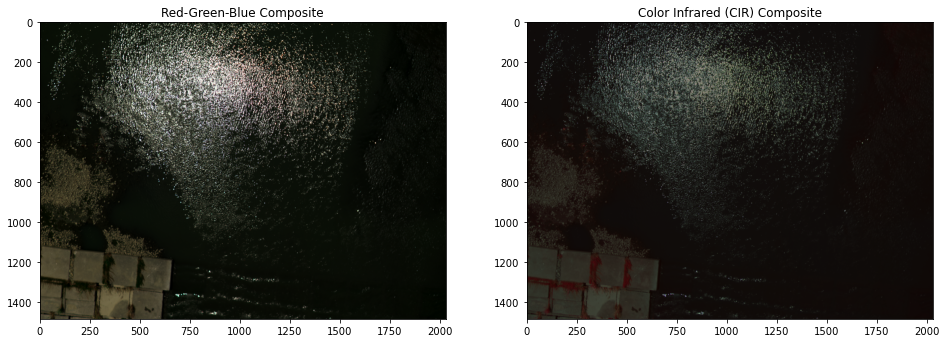

In [78]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green'),
                    capture.band_names_lower().index('blue')]
cir_band_indices = [capture.band_names_lower().index('nir'),
                    capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green')]

# Create a normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

rgb = im_display[:,:,rgb_band_indices]

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

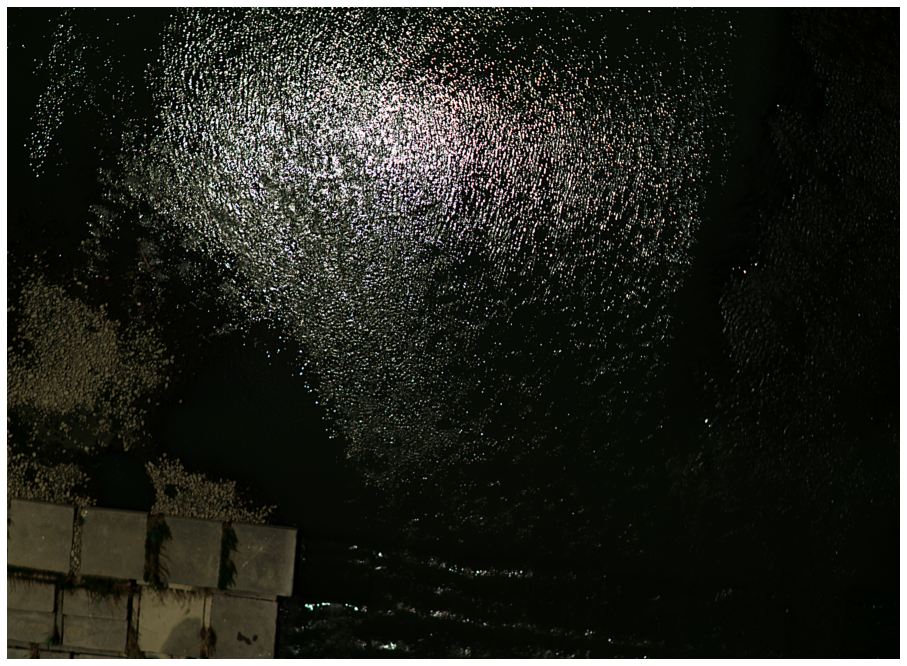

In [79]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 0.9
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

In [80]:
import imageio
imtype = 'png' # or 'jpg'
imageio.imwrite('rgb.'+imtype, (255*gamma_corr_rgb).astype('uint8'))
imageio.imwrite('cir.'+imtype, (255*cir).astype('uint8'))

In [81]:
from osgeo import gdal, gdal_array
rows, cols, bands = im_display.shape
driver = gdal.GetDriverByName('GTiff')
filename = "bgrne" #blue,green,red,nir,redEdge

if im_aligned.shape[2] == 6:
    filename = filename + "t" #thermal
outRaster = driver.Create(filename+".tiff", cols, rows, im_aligned.shape[2], gdal.GDT_UInt16)

normalize = (img_type == 'radiance') # normalize radiance images to fit with in UInt16

# Output a 'stack' in the same band order as RedEdge/Alutm
# Blue,Green,Red,NIR,RedEdge[,Thermal]
# reflectance stacks are output with 32768=100% reflectance to provide some overhead for specular reflections
# radiance stacks are output with 65535=100% radiance to provide some overhead for specular reflections

# NOTE: NIR and RedEdge are not in wavelength order!

multispec_min = np.min(im_aligned[:,:,1:5])
multispec_max = np.max(im_aligned[:,:,1:5])

for i in range(0,5):
    outband = outRaster.GetRasterBand(i+1)
    if normalize:
        outdata = imageutils.normalize(im_aligned[:,:,i],multispec_min,multispec_max)
    else:
        outdata = im_aligned[:,:,i]
        outdata[outdata<0] = 0
        outdata[outdata>2] = 2
    
    outdata = outdata*32767
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()

if im_aligned.shape[2] == 6:
    outband = outRaster.GetRasterBand(6)
    outdata = im_aligned[:,:,5] * 100 # scale to centi-C to fit into uint16
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()
outRaster = None

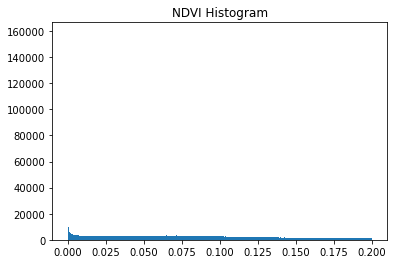

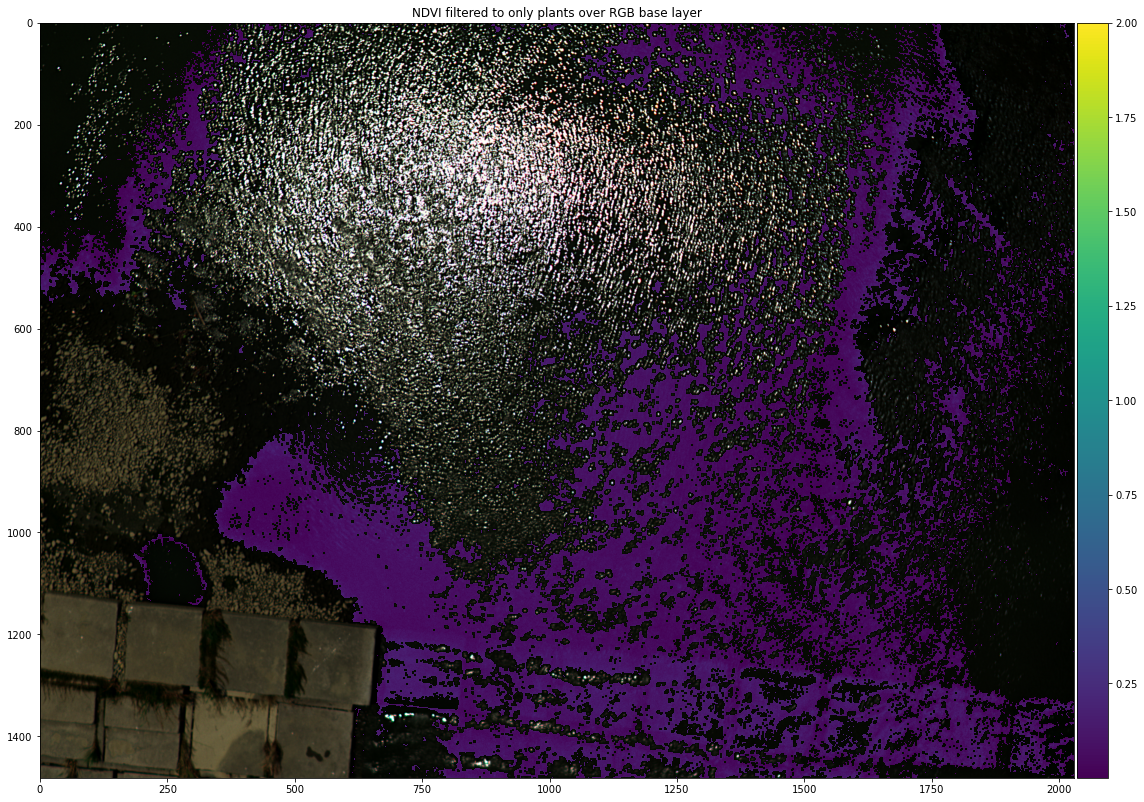

In [82]:
from micasense import plotutils
import matplotlib.pyplot as plt

blue_band = capture.band_names_lower().index('blue')
green_band = capture.band_names_lower().index('green')
red_band = capture.band_names_lower().index('red')
nir_band = capture.band_names_lower().index('nir')


np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (im_aligned[:,:,nir_band])

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] > 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(im_aligned[:,:,3],  100.0)
    ndvi = np.ma.masked_where(im_aligned[:,:,green_band] > lower_pct_radiance, ndvi) 
    
# Compute and display a histogram
ndvi_hist_min = np.min(ndvi)
ndvi_hist_max = np.max(ndvi)
fig, axis = plt.subplots(1, 1)
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

#min_display_ndvi = 0.45 # further mask soil by removing low-ndvi values
min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
#figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig('ndvi_over_rgb.png')

In [83]:
rededge_band = capture.band_names_lower().index('red edge')

blue=im_aligned[:,:,blue_band]
blue = blue.astype('float64')
np.save('blue', blue)

green=im_aligned[:,:,green_band]
green = green.astype('float64')
np.save('green', green)

red=im_aligned[:,:,red_band]
red = red.astype('float64')
np.save('red', red)

rededge=im_aligned[:,:,rededge_band]
red = rededge.astype('float64')
np.save('rededge', rededge)

nir=im_aligned[:,:,nir_band]
nir = nir.astype('float64')
np.save('nir', nir)

thermal = im_aligned[:,:,5]
thermal = thermal.astype('float64')
np.save('thermal', thermal)